# Benchmarking predictors

Compares three prediction tools fot MHC-I

In [1]:
import os, sys, math
import numpy as np
import pandas as pd
pd.set_option('display.width', 130)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
import epitopepredict as ep
from epitopepredict import sequtils, base, peptutils, mhclearn
from IPython.display import display, HTML, Image
from importlib import reload

In [ ]:
def evaluate_predictor(P, allele):

    data = mhclearn.get_evaluation_set2(allele, length=9)
    print (len(data))
    P.predict_peptides(list(data.peptide), alleles=allele, threads=12)
    x = P.get_scores(allele)
    #x = P.data
    x = data.merge(x,on='peptide') 
    #print (x)
    #x.plot(x='ic50',y='score',kind='scatter',s=20,)
    #auc = auc_score(x.log50k_x,x.log50k_y,cutoff=.426)
    auc = ep.auc_score(x.ic50,x.score,cutoff=500)
    return auc, data

reload(base)
reload(mhclearn)

def run_tests():
    preds = [base.get_predictor('basicmhc1'),
             base.get_predictor('netmhcpan',scoring='affinity'),
             ep.get_predictor('mhcflurry')]
    comp=[]
    test_alleles = mhclearn.get_allele_names()[:25]
    omit = ['H-2-Kb','Mamu-A*01:01']
    for P in preds:
        m=[]
        for a in test_alleles:
            if a in omit: continue
            try:
                auc,df = evaluate_predictor(P, a)
                m.append((a,auc,len(df)))            
            except Exception as e:
                print (a,e)
                pass
            print (P, a, auc)
        m=pd.DataFrame(m,columns=['allele','score','size'])
        m['name'] = P.name
        comp.append(m)
    return comp

comp = run_tests() 

name              basicmhc1  mhcflurry  netmhcpan
allele      size                                 
H-2-Db      1794   0.863064   0.806853   0.882121
HLA-A*01:01 3115   0.884788   0.881578   0.853773
HLA-A*02:01 8159   0.897032   0.895628   0.909828
HLA-A*02:02 2259   0.860325   0.840108   0.871340
HLA-A*02:03 3794   0.891755   0.878566   0.907822
HLA-A*02:06 3309   0.837279   0.815194   0.864054
HLA-A*03:01 4678   0.869376   0.887260   0.868564
HLA-A*11:01 3955   0.894145   0.880470   0.888796
HLA-A*24:02 1948   0.814168   0.855601   0.840761
HLA-A*26:01 2935   0.837660   0.814759   0.831024
HLA-A*31:01 3333   0.863755   0.859533   0.869949
HLA-A*33:01 1689   0.880872   0.867072   0.874512
HLA-A*68:01 1793   0.872222   0.835292   0.872130
HLA-A*68:02 3203   0.861798   0.840834   0.865945
HLA-A*69:01 2085   0.864760   0.695065   0.799468
HLA-B*07:02 3381   0.914323   0.892246   0.911606
HLA-B*08:01 2719   0.881328   0.826553   0.879317
HLA-B*15:01 3538   0.856579   0.841617   0.850627


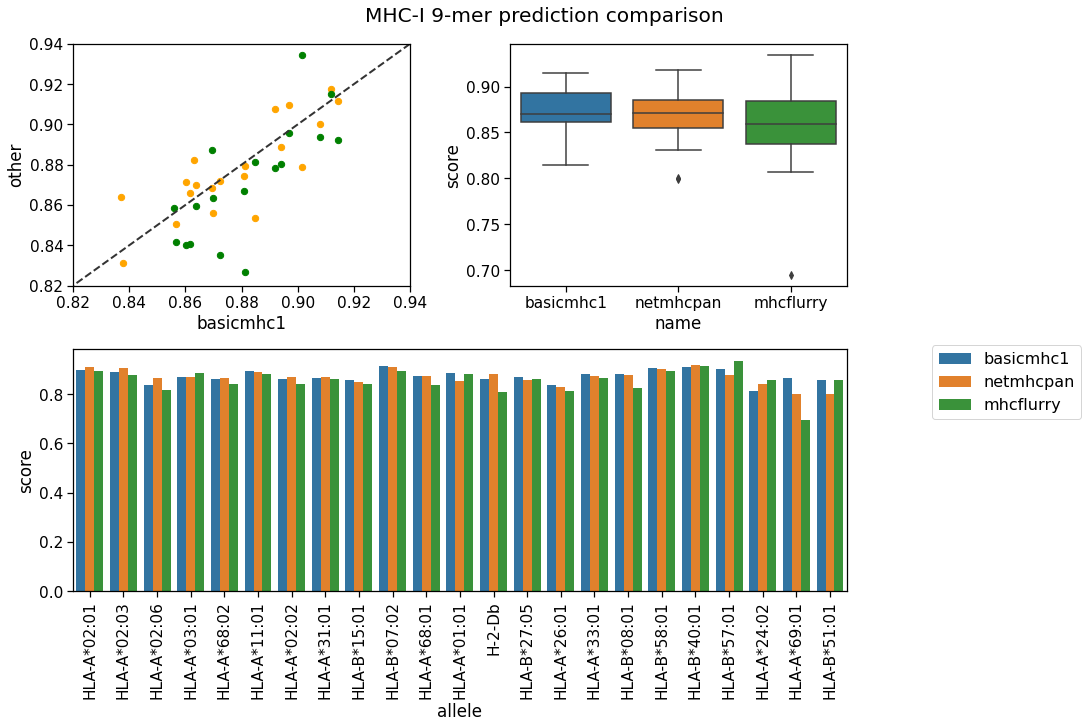

In [10]:
c=pd.concat(comp)
x=pd.pivot_table(c,index=['allele','size'],columns='name',values='score')
print (x)
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
#display(x.style.apply(highlight_max,1))
#print(c)
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = fig.add_gridspec(2, 2, hspace=1)
ax = fig.add_subplot(gs[0])
x.plot(x='basicmhc1',y='netmhcpan',kind='scatter',s=40,c='orange',ax=ax)
x.plot(x='basicmhc1',y='mhcflurry',kind='scatter',s=40,c='green',ax=ax)
ax.plot((0,1), (0,1), ls="--", lw=2, c=".2")
ax.set_xlim(.82,.94);ax.set_ylim(.82,.94)
ax.set_ylabel('other')
ax = fig.add_subplot(gs[1])
sns.boxplot(data=c,y='score',x='name',ax=ax)
ax = fig.add_subplot(gs[2:])
g=sns.barplot(data=c,y='score',x='allele',hue='name', ax=ax)
plt.legend(bbox_to_anchor=(1.1, 1.05),fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=90)
fig.suptitle('MHC-I 9-mer prediction comparison')
plt.savefig('basicmhc1_benchmarks.jpg', dpi=150)
x.to_csv('benchmarks.csv')